# Introduction
Cardiovascular diseases are among the leading causes of death globally, claiming millions of lives each year, according to the World Health Organization (WHO). Early detection and intervention are crucial for reducing mortality rates and minimizing long-term health impacts. However, traditional diagnostic methods such as stress testing and manual evaluations can be resource-intensive and may not always be accessible to all patients. Artificial Intelligence (AI) offers a promising alternative by providing efficient, scalable solutions for heart disease prediction.<br>

The UCI Heart Disease dataset is a widely recognized benchmark used for predicting the severity of heart disease. This dataset contains patient records from various medical institutions, with clinical features like age, cholesterol levels, blood pressure, maximum heart rate, and chest pain type. The dataset aims to classify patients into five severity levels (0-4), where 0 indicates no heart disease, and 4 represents the most severe condition. Traditional machine learning techniques such as Support Vector Machines (SVMs) and Random Forests have been commonly applied to analyze this dataset. However, by incorporating a Graph Neural Network (GNN), we aim to explore a more advanced approach that can take advantage of the structured relationships between patients.<br>

In our previous semester's machine learning project, we explored various algorithms, including Decision Trees, Random Forests, Support Vector Machines, Logistic Regression, and Neural Networks, using tools like Scikit-learn, WEKA, and MAADSBML. Among these, the neural network demonstrated the best performance.

Our neural network model featured two hidden layers with 64 and 32 neurons, totaling 3,141 parameters. To mitigate overfitting, we applied a dropout rate of 0.3 and used normalization between layers. The classification report for this model is given at the end of the report for the sake of comparison.

Building on our previous work, our current project applies a Graph Neural Network (GNN) to the same dataset, aiming to optimize the model and enhance prediction performance. By leveraging the graph structure of patient relationships, we seek to encode richer information, enabling the model to uncover hidden patterns and insights within the data. Graph Neural Networks (GNNs) offer a powerful approach for heart disease prediction by capturing the relationships between patients, leading to a more comprehensive representation of the data. Unlike traditional models that treat patients independently, GNNs facilitate information sharing among those with similar medical histories, enhancing classification accuracy and robustness. By recognizing patterns across patient clusters, GNNs uncover hidden correlations between risk factors.

  

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00


In [ ]:
# This is the start of data pre-processing
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Agents project ')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn import Dropout
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GraphNorm

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from networkx.algorithms.community import greedy_modularity_communities

from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GATConv

from torch_geometric.utils import to_dense_adj
from torch.nn.functional import one_hot

import torch
import networkx as nx
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj





In [ ]:
data = pd.read_csv('data_preprocessed.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


# Methods
In our approach, we represent each patient as a node, with their medical attributes serving as the node features. The challenge was to determine how to form connections, or edges, between patients to best capture meaningful relationships.

We explored three methods to construct these edges:




## 1. Manual Addition Based on Medical Data:
Initially, we attempted a straightforward approach by manually adding edges based on predefined medical criteria. However, this proved to be unreliable, as the complexity of medical data made it difficult to capture nuanced relationships. We will consider two approaches: unweighted and weighted edges. Furthermore, we would like to pass the label for the neighboring patients to help estimate the label for each patient in training; to achieve this we will create a mask that will pass only the label for the neighboring nodes and masks the label for the current node.

In [ ]:
# Select 5 most important features and add edges based on that
# Define feature-based grouping functions
def get_age_group(age):
    if age <= 35:
        return "young"
    elif age <= 55:
        return "middle"
    else:
        return "old"

def get_chol_group(chol):
    if chol < 200:
        return "low"
    elif chol < 240:
        return "borderline"
    else:
        return "high"

def get_thalach_group(thalach):
    if thalach < 100:
        return "low"
    elif thalach <= 150:
        return "moderate"
    else:
        return "high"

def get_oldpeak_group(oldpeak):
    if oldpeak < 1.0:
        return "low_risk"
    elif oldpeak <= 2.5:
        return "medium_risk"
    else:
        return "high_risk"

# Add edges based on feature similarity
for i in range(number_of_patients):
    for j in range(i + 1, number_of_patients):
        if get_age_group(data.iloc[i]['age']) == get_age_group(data.iloc[j]['age']):
            G.add_edge(i, j)
        if get_chol_group(data.iloc[i]['chol']) == get_chol_group(data.iloc[j]['chol']):
            G.add_edge(i, j)
        if get_thalach_group(data.iloc[i]['thalach']) == get_thalach_group(data.iloc[j]['thalach']):
            G.add_edge(i, j)
        if get_oldpeak_group(data.iloc[i]['oldpeak']) == get_oldpeak_group(data.iloc[j]['oldpeak']):
            G.add_edge(i, j)
        if data.iloc[i]['cp'] == data.iloc[j]['cp']:  # Chest pain type
            G.add_edge(i, j)
# Convert to Pytorhc Geometric
edge_index = torch.tensor(list(G.edges)).t().contiguous()
# Converting attributes to a tensor
x = torch.tensor([data['features'] for _, data in G.nodes(data=True)], dtype=torch.float)
# Extract the label of each node
y = torch.tensor([data['label'] for _, data in G.nodes(data=True)], dtype=torch.long)
number_of_categories = len(y.unique())
# Creating a Pytorch Geometric tensor
data_geom = Data(x=x, edge_index=edge_index, y=y)
### Define the training and testing set by a train_mask
# Get the number of nodes
num_nodes = data_geom.num_nodes
# Initialize mask with all False
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# Set 80% of nodes as training nodes
train_mask[:int(0.8 * num_nodes)] = True
# Assign to data object
data_geom.train_mask = train_mask

## 2. Autoencoders:
We then experimented with autoencoders to identify similarities between patients by compressing and reconstructing their features. While this showed some improvement, the results were inconsistent and did not significantly enhance model performance.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU()  # To reconstruct the input
        )
        self.norm = nn.LayerNorm(normalized_shape=13)
        self.norm2= nn.LayerNorm(normalized_shape=hidden_dim)

    def forward(self, x):
        x_normalized = self.norm(x)
        encoded = self.norm2(self.encoder(x_normalized))

        decoded = self.decoder(encoded)
        return encoded, decoded


In [ ]:
# Convert patient attributes to a PyTorch tensor
features = torch.tensor(data.drop("num", axis=1).values, dtype=torch.float)

# Define model, loss function, and optimizer
input_dim = features.shape[1] #13
hidden_dim = 20# Compressed latent space
autoencoder = Autoencoder(input_dim, hidden_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.1)

In [ ]:
# Training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    encoded, decoded = autoencoder(features)
    loss = criterion(decoded, features)  # Reconstruction loss
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 23.6454
Epoch 100, Loss: 23.9204
Epoch 200, Loss: 23.6723
Epoch 300, Loss: 27.8375
Epoch 400, Loss: 23.7080


In [ ]:
# Convert features and labels
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(data["num"].values)

# Create PyTorch Geometric graph
data_geom2 = Data(x=x, edge_index=edge_index, y=y)
### Define the training and testing set by a train_mask
# Get the number of nodes
num_nodes = data_geom2.num_nodes
# Initialize mask with all False
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# Set 80% of nodes as training nodes
train_mask[:int(0.8 * num_nodes)] = True
# Assign to data object
data_geom2.train_mask = train_mask

/var/folders/ry/1l9br0wd433fd3xsqyszbnlr0000gn/T/ipykernel_37405/1778025935.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(features, dtype=torch.float)


## 3. K-Nearest Neighbors (KNN):
Before applying KNN, we will normalize the dataset to ensure that no single feature disproportionately influences the Euclidean distance. In constructing the graph, each patient is represented as a node with clinical features and a classification label. However, during training, we aim to prevent a node from directly using its own label while still leveraging the labels of its neighbors. To achieve this, we introduce a masked label mechanism where each node only has access to the aggregated labels of its connected neighbors, ensuring that its own label remains hidden. Ultimately, we found that using KNN yielded the most effective results. By calculating the similarity between patient feature vectors, we connected each patient to its 5 nearest neighbors based on their Euclidean distance. This graph structure provided a more accurate representation of patient relationships, resulting in improved predictive performance.


### Feature Normalization
Before applying KNN, we will normalize the dataset to ensure that no single feature disproportionately influences the Euclidean distance, allowing all features to contribute equally.

In [ ]:
# Normalize the data except the target value
cols_to_normalize  = data.columns.difference(['num'])

scaler = StandardScaler()
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])

print(data.head())

### Label Maskig
In a graph-based learning approach, we want each node to make predictions based on its neighbors rather than relying on its own label. To achieve this, we construct a masked label representation where a node’s label is hidden from itself but remains accessible to its neighbors. This is done by representing the graph structure as an adjacency matrix \( A \), where

$$ A_{ij} = 1 $$

if node \( i \) is connected to node \( j \), and 0 otherwise. Given a label matrix \( Y \) where each row represents a node’s one-hot encoded class label, we compute the masked labels using matrix multiplication:

$$ Y' = A Y $$

The result is a new label matrix where each node \( i \) now holds a weighted sum of the labels of its connected neighbors but does not have direct access to its own label. This approach prevents label leakage, ensuring that the model learns from the structure of the graph and the relationships between nodes rather than memorizing its own classification.


In [ ]:
def mask_self_labels(data):
    """ Removes each node's own label but keeps the labels of neighbors """
    num_nodes = data.x.shape[0]

    # Convert edge_index to adjacency matrix
    adj = to_dense_adj(data.edge_index, max_num_nodes=5).squeeze(0)

    # Create a masked label matrix where each node's own label is hidden
    masked_labels = one_hot(data.y, num_classes=5).float()
    masked_labels = adj @ masked_labels  # Aggregate neighbor labels

    return masked_labels


### Weighted vs. Unweighted Edges
To further refine our model, we experimented with both weighted and unweighted edges:

Unweighted Edges: Simply indicated the presence or absence of a connection, treating all relationships equally.

Weighted Edges: Assigned weights based on the similarity between patient features, allowing the model to capture the strength of the relationship. The edges are weighted inversely to the Euclidean distance, ensuring closer nodes have stronger connections.

This dual approach led us to create two distinct graph representations, which are reflected in the implementation sections for both weighted and unweighted edge data. Through this method, we aim to leverage GNNs to uncover hidden patterns and achieve robust heart disease predictions.

#### KNN for Unweighted Edges
We extracted the features (excluding the target variable) and applied KNN with K = 5 to find the 5 nearest neighbors for each patient using Euclidean distance. Edges were then created between each patient and their nearest neighbors, ensuring no self-loops were created.

In [ ]:
# Extract features and labels
features = data.drop(columns=["num"]).values  # Feature matrix
labels = data["num"].values  # Target labels

# One-hot encode labels for multi-class
num_classes = len(set(labels))
labels_onehot = F.one_hot(torch.tensor(labels), num_classes=num_classes).float()

# Use KNN to find nearest neighbors
K = 5  # Number of neighbors
nbrs = NearestNeighbors(n_neighbors=K, metric="euclidean").fit(features)
_, indices = nbrs.kneighbors(features)  # Get K-nearest neighbor indices

# Create a graph and add nodes
G = nx.Graph()
for i in range(len(data)):
    G.add_node(i, features=features[i], label=labels[i])

# Add edges based on KNN
for i in range(len(data)):
    for j in indices[i]:  # Connect each node to its K-nearest neighbors
        if i != j:  # Avoid self-loops
            G.add_edge(i, j)

# Convert to PyTorch Geometric format
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
x = torch.tensor([data["features"] for _, data in G.nodes(data=True)], dtype=torch.float)
y = torch.tensor([data["label"] for _, data in G.nodes(data=True)], dtype=torch.long)

# Convert edge_index to adjacency matrix
adj_matrix = to_dense_adj(edge_index, max_num_nodes=x.shape[0]).squeeze(0)

# Aggregate neighbor labels (mask self-labels)
masked_labels = adj_matrix @ labels_onehot  # Neighbor label aggregation

# Create PyTorch Geometric Data object with masked labels
data_geom3 = Data(x=x, edge_index=edge_index, y=y, masked_labels=masked_labels)

# Print dataset information
print(data_geom3)


Data(x=[303, 13], edge_index=[2, 871], y=[303], masked_labels=[303, 5])


#### Plot of the KNN results
The KNN-based graph representation of patients reveals distinct clustering patterns, with patients of similar heart disease severity tending to be more interconnected. Those with no heart disease are primarily linked to others with little to no heart problems, while patients with severe conditions are often connected to others with similar severities. Intermediate severity cases frequently act as bridges between healthier and more severe patients, indicating gradual transitions in disease progression. The graph effectively captures meaningful relationships, providing insights into how shared medical characteristics influence patient connections. This structured representation offers valuable information for improving heart disease prediction models.


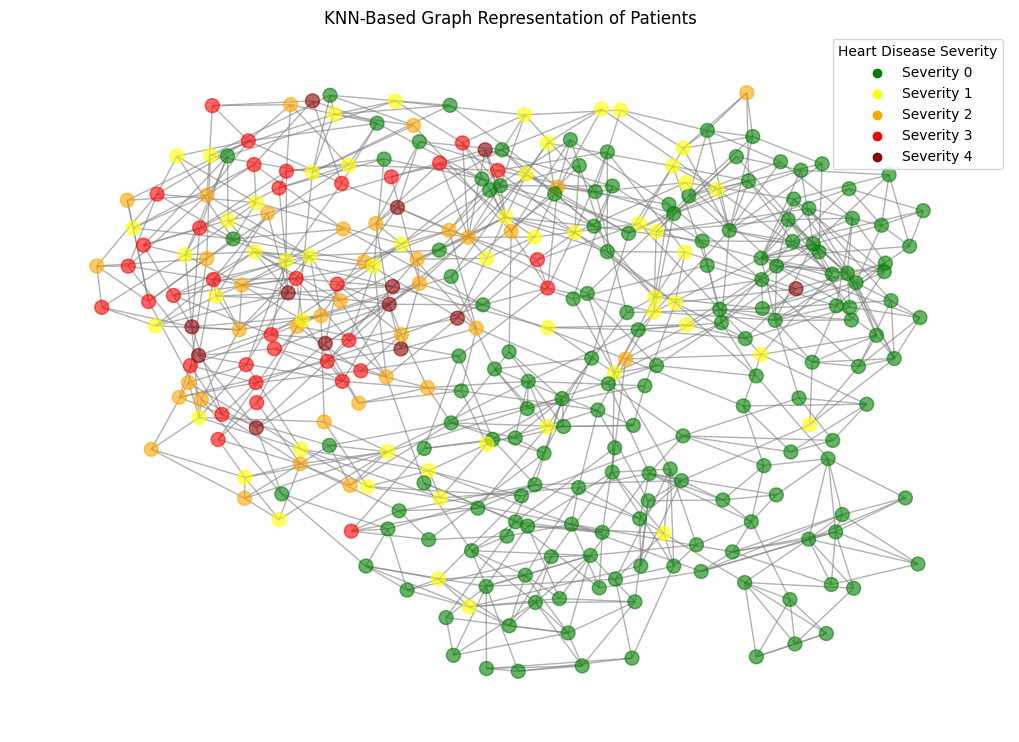

In [ ]:
### Optional
# Reassign labels into 3 clusters: 0 (Low), 1 (Medium), 2 (High)
label_mapping = {0: 0, 1: 1, 2: 1, 3: 1, 4: 2}
labels_mapped = np.array([label_mapping[label] for label in data["num"].values])
# Define color map for different heart disease severity levels
color_map = ["green", "yellow", "orange","red", "darkred"]
node_colors = [color_map[label] for label in labels]  # Assign colors based on labels

plt.figure(figsize=(10, 7))

# Use Kamada-Kawai layout for better visualization
pos = nx.kamada_kawai_layout(G)

# Draw graph
nx.draw(G, pos, with_labels=False , node_size=100, node_color=node_colors, edge_color="gray", alpha=0.6)

# Add legend for disease severity
for i, color in enumerate(color_map):
    plt.scatter([], [], color=color, label=f"Severity {i}")
plt.legend(title="Heart Disease Severity")

plt.title("KNN-Based Graph Representation of Patients")
plt.show()


### KNN for Weighted Edges
By using KNN to define edges with weights, we aim to enhance the graph's representation of these relationships and improve the performance of Graph Neural Networks (GNNs) in predicting heart disease.


In [ ]:
# Extract features and labels
features = data.drop(columns=["num"]).values  # Feature matrix
labels = data["num"].values  # Target labels

# One-hot encode labels for multi-class classification
num_classes = len(set(labels))
labels_onehot = F.one_hot(torch.tensor(labels), num_classes=num_classes).float()

# Use KNN to find nearest neighbors
K = 5  # Number of neighbors
nbrs = NearestNeighbors(n_neighbors=K, metric="euclidean").fit(features)
distances, indices = nbrs.kneighbors(features)  # Get distances and indices

# Create a graph
G = nx.Graph()
for i in range(len(data)):
    G.add_node(i, features=features[i], label=labels[i])

# Add edges with weights > 0.5
for i in range(len(features)):
    for j, distance in zip(indices[i], distances[i]):
        if i != j:  # Avoid self-loops
            weight = 1.0 / (distance + 1e-6)  # Add small constant to prevent division by zero
            if weight > 0:
                G.add_edge(i, j, weight=weight)

# Convert to PyTorch Geometric format
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
x = torch.tensor([data["features"] for _, data in G.nodes(data=True)], dtype=torch.float)
y = torch.tensor([data["label"] for _, data in G.nodes(data=True)], dtype=torch.long)

# Convert edge_index to adjacency matrix
adj_matrix = to_dense_adj(edge_index, max_num_nodes=x.shape[0]).squeeze(0)

# Compute masked labels (only neighbor labels, not self-label)
masked_labels = adj_matrix @ labels_onehot  # Aggregate neighbor labels

# Create PyTorch Geometric Data object with masked labels
data_weighted = Data(x=x, edge_index=edge_index, y=y, masked_labels=masked_labels)

# Print dataset information
print(data_weighted)
print(data.head())  # Check masked labels in the DataFrame


### Exploratory Data Analysis

The initial dataset contained missing values in two features: the "number of major vessels" (ca) feature, which had four missing values, and the "thalassemia" (thal) feature, which had two missing values. Given the relatively small size of the dataset, dropping rows with missing values was not a viable option, as this would significantly reduce the amount of usable data. Therefore, in our previous project, we imputed the missing values in the numerical "ca" feature by replacing them with the mean of the column. For the categorical "thal" feature, we replaced the missing values with the mode of the column. For this project, we will treat the missing values similarly.


As illustrated in Figure 2, a significant challenge with the dataset is the class imbalance, with most samples having a heart disease index of 0, indicating no heart disease. This imbalance may cause the model to favor predicting class 0. To mitigate this, we applied stratified sampling to maintain a similar class distribution in both the training and testing sets. Additionally, we will use a weighted loss function to penalize misclassifications more heavily in the underrepresented classes. The dataset will be split into training and testing subsets using an 80/20 ratio, with a train_mask created within the PyTorch Geometric dataset to mask 20% of the data for testing. The stratified sampling ensures the class distribution remains consistent across both subsets.


<ipython-input-9-b1c979f28f36>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=severity_counts.index, y=severity_counts.values, palette="viridis")


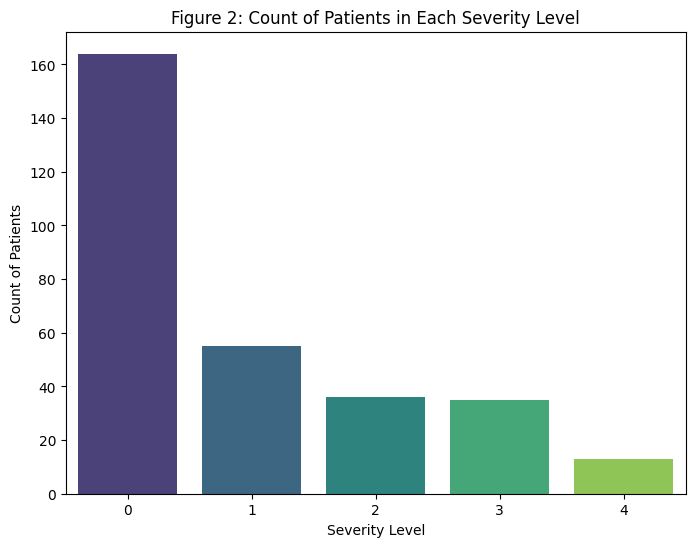

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = data["num"].values  # Severity levels

# Count the occurrences of each severity level
severity_counts = pd.Series(labels).value_counts().sort_index()  # Count and sort by label

# Plot the count of each classification
plt.figure(figsize=(8, 6))
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette="viridis")

plt.title("Figure 2: Count of Patients in Each Severity Level")
plt.xlabel("Severity Level")
plt.ylabel("Count of Patients")
plt.xticks(rotation=0)  # Optionally rotate x-axis labels if needed
plt.show()


As shown above, the data is not balanced; this can be problematic as some classes are over-represented (e.g. class 1) to the model while others are under-represented (e.g. class 4). We will use class weights to penalize miss-classification for these under-represented classes.

In [ ]:
### Create the test and train sets according to the dataset distribution
# Get the connected components or communities in the graph
communities = list(greedy_modularity_communities(G))

# Flatten the list of nodes into a list of (node, label) tuples
nodes_labels = [(node, G.nodes[node]['label']) for community in communities for node in community]

# Separate the nodes and their labels
nodes = [node for node, label in nodes_labels]
labels = [label for node, label in nodes_labels]
num_nodes = len(nodes)
# Perform a stratified split, preserving communities
X_train, X_test, y_train, y_test = train_test_split(nodes, labels, test_size=0.2, stratify=labels)

# Create the train mask
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# Set 80% of nodes as training nodes
train_mask[X_train] = True
# Assign to data object
data_geom3.train_mask = train_mask
data_weighted.train_mask = train_mask

In [ ]:
# Create class-weights for penalizing miss-classification of under-represented classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels )

# Convert class weights to a tensor (to use in GNN loss function)
class_weights = torch.tensor(class_weights, dtype=torch.float)

## Model : Graph Neural Networks Work
Graph Neural Networks (GNNs) are a type of deep learning model designed for graph-structured data. Unlike traditional neural networks that process Euclidean data (e.g., images, text), GNNs operate on graphs, where data points (nodes) are interconnected. For this project, we implemented two graph-based models, Graph Convolutional Network (GCN) and Graph Attention Network (GAT), to predict heart disease from the graph representations of patient data. Both models are designed to work with graph-structured data, where each patient is represented as a node, and edges are formed based on similarities between patients. The GCN model consists of two Graph Convolutional layers with graph normalization applied after the first layer. Dropout (with a rate of 0.3) is used after the first layer to prevent overfitting, and ReLU is applied as the activation function. The second GCN layer projects the features to the output dimension, and softmax is applied for classification. Similarly, the GAT model uses two Graph Attention layers, where attention mechanisms are introduced to weigh neighboring nodes differently, allowing the model to focus on the most relevant neighbors. Like the GCN model, graph normalization and dropout are applied to stabilize learning and reduce overfitting. Both models were designed with an input size corresponding to the number of clinical features, and the output layer provides the classification result. The use of GCN and GAT models allows us to capture complex dependencies and relationships between patients, improving prediction accuracy compared to traditional machine learning methods.


### Models with Unweighted Edges

In [ ]:
def weighted_loss(output, labels, class_weights=class_weights):
    # Compute the CrossEntropyLoss with class weights
    return F.cross_entropy(output, labels, weight=class_weights)

#### Graph Convolutional Network

In [ ]:
class MaskedGCN(nn.Module):
    def __init__(self, in_features, d_model, out_features, dropout_rate=0.3):
        super(MaskedGCN, self).__init__()
        self.conv1 = GCNConv(in_features + num_classes, d_model)  # Extra input for labels
        self.norm1 = GraphNorm(d_model)
        self.conv2 = GCNConv(d_model, out_features)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        masked_labels = data.masked_labels  # Get labels of neighbors only

        # Append masked labels to features
        x = torch.cat([x, masked_labels], dim=1)
        # First GCN Layer
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second GCN Layer
        x = self.conv2(x, edge_index)

        return F.softmax(x, dim=1)


In [ ]:
model = MaskedGCN(in_features=data_geom.x.shape[1], d_model=16, out_features=num_classes)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Define a learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

# Count trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the result
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 437


In [ ]:
# Train the model
def train(model, data, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = weighted_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Train the model
train(model, data_geom, epochs = 100)


In [ ]:
# Ensure the model is in evaluation mode
model.eval()
Test_set = data_geom
with torch.no_grad():
    y_prob = model(Test_set)[~Test_set.train_mask]  # Only test nodes
    y_test = Test_set.y[~Test_set.train_mask]  # True labels for test nodes

    # Get predicted probabilities (softmax for multi-class)
    #y_prob = torch.nn.functional.softmax(logits_test, dim=1).numpy()

    # Get predicted classes
    pred_test = y_prob.argmax(dim=1).numpy()
    y_test = y_test.numpy()

    # Compute test accuracy
    test_acc = accuracy_score(y_test, pred_test)

    # Compute ROC AUC (multi-class setting)
    test_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")  # "ovr" for one-vs-rest

    # Classification report (precision, recall, F1-score)
    report = classification_report(y_test, pred_test)

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC-ROC: {test_auc:.4f}")
    print("\nClassification Report:\n", report)


Test Accuracy: 0.5738
Test AUC-ROC: 0.7920

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.64      0.76        33
           1       0.10      0.09      0.10        11
           2       0.54      1.00      0.70         7
           3       0.62      0.71      0.67         7
           4       0.12      0.33      0.18         3

    accuracy                           0.57        61
   macro avg       0.47      0.55      0.48        61
weighted avg       0.67      0.57      0.60        61



### Constructing the Graph Attention Network

In [ ]:
# Define the GAT with Dropout and Graph Normalization
class GATmodel(nn.Module):
    def __init__(self, in_features, d_model, out_features, dropout_rate=0.3):
        super(GATmodel, self).__init__()
        # The input features for the first layer should include the original features + masked_labels
        self.conv1 = GATConv(in_features + 5, d_model)  # +5 for masked_labels
        self.norm1 = GraphNorm(d_model)  # Graph Normalization after first layer
        self.norm2 = nn.LayerNorm(normalized_shape=in_features + 5) # Update normalization shape
        self.conv2 = GATConv(d_model, out_features)  # Use GATConv for the second layer
        self.dropout = Dropout(dropout_rate)  # Dropout to reduce overfitting

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        masked_labels = data.masked_labels  # Get labels of neighbors only

        # Append masked labels to features
        x = torch.cat([x, masked_labels], dim=1)
        # First GAT Layer
        x = self.norm2(x)
        # First GAT Layer + Normalization + ReLU + Dropout
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second GAT Layer
        x = self.conv2(x, edge_index)

        # Apply log softmax to get results
        return F.softmax(x, dim=1)

In [ ]:
# Instantiate the model
model = GATmodel(in_features=data_geom3.x.shape[1], d_model=16, out_features=5)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Define a learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

# Count trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the result
print(f"Total trainable parameters: {num_params}")

In [ ]:
# Train the model
def train(model, data, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = weighted_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Train the model
train(model, data_geom3, epochs = 50)


In [ ]:
#Evaluation with the GAT:
model.eval()
Test_set = data_geom3
with torch.no_grad():
    y_prob = model(Test_set)[~Test_set.train_mask]  # Only test nodes
    y_test = Test_set.y[~Test_set.train_mask]  # True labels for test nodes

    # Get predicted probabilities (softmax for multi-class)
    #y_prob = torch.nn.functional.softmax(logits_test, dim=1).numpy()

    # Get predicted classes
    pred_test = y_prob.argmax(dim=1).numpy()
    y_test = y_test.numpy()

    # Compute test accuracy
    test_acc = accuracy_score(y_test, pred_test)

    # Compute ROC AUC (multi-class setting)
    test_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")  # "ovr" for one-vs-rest

    # Classification report (precision, recall, F1-score)
    report = classification_report(y_test, pred_test)

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC-ROC: {test_auc:.4f}")
    print("\nClassification Report:\n", report)



### Working with Weighted Edges

#### Graph Convolutional Neural Network

In [ ]:
class MaskedGCN(nn.Module):
    def __init__(self, in_features, d_model, out_features, dropout_rate=0.3):
        super(MaskedGCN, self).__init__()
        self.conv1 = GCNConv(in_features + num_classes, d_model)  # Extra input for labels
        self.norm1 = GraphNorm(d_model)
        self.conv2 = GCNConv(d_model, out_features)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index, data.edge_weight
        masked_labels = data.masked_labels  # Get labels of neighbors only

        # Append masked labels to features
        x = torch.cat([x, masked_labels], dim=1)
        # First GCN Layer
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second GCN Layer
        x = self.conv2(x, edge_index)

        return F.softmax(x, dim=1)


In [ ]:
# Instantiate the model
model = GCNmodel(in_features=data_weighted.x.shape[1], d_model=16, out_features=5)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Define a learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

# Count trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the result
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 473


In [ ]:
# Train the model
def train(model, data, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = weighted_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Train the model
train(model, data_weighted, epochs = 100)


In [ ]:
# Ensure the model is in evaluation mode
model.eval()
Test_set = data_weighted
with torch.no_grad():
    y_prob = model(Test_set)[~Test_set.train_mask]  # Only test nodes
    y_test = Test_set.y[~Test_set.train_mask]  # True labels for test nodes

    # Get predicted probabilities (softmax for multi-class)
    #y_prob = torch.nn.functional.softmax(logits_test, dim=1).numpy()

    # Get predicted classes
    pred_test = y_prob.argmax(dim=1).numpy()
    y_test = y_test.numpy()

    # Compute test accuracy
    test_acc = accuracy_score(y_test, pred_test)

    # Compute ROC AUC (multi-class setting)
    test_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")  # "ovr" for one-vs-rest

    # Classification report (precision, recall, F1-score)
    report = classification_report(y_test, pred_test)

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC-ROC: {test_auc:.4f}")
    print("\nClassification Report:\n", report)


Test Accuracy: 0.6721
Test AUC-ROC: 0.7815

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84        33
           1       0.50      0.45      0.48        11
           2       0.43      0.43      0.43         7
           3       0.57      0.57      0.57         7
           4       0.33      0.33      0.33         3

    accuracy                           0.67        61
   macro avg       0.53      0.53      0.53        61
weighted avg       0.67      0.67      0.67        61



#### Graph Attention Network

In [ ]:
# Define the GAT with Dropout and Graph Normalization
class GATmodel(nn.Module):
    def __init__(self, in_features, d_model, out_features, dropout_rate=0.3):
        super(GATmodel, self).__init__()
        # The input features for the first layer should include the original features + masked_labels
        self.conv1 = GATConv(in_features + 5, d_model)  # +5 for masked_labels
        self.norm1 = GraphNorm(d_model)  # Graph Normalization after first layer
        self.norm2 = nn.LayerNorm(normalized_shape=in_features + 5) # Update normalization shape
        self.conv2 = GATConv(d_model, out_features)  # Use GATConv for the second layer
        self.dropout = Dropout(dropout_rate)  # Dropout to reduce overfitting

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        masked_labels = data.masked_labels  # Get labels of neighbors only

        # Append masked labels to features
        x = torch.cat([x, masked_labels], dim=1)
        # First GAT Layer
        x = self.norm2(x)
        # First GAT Layer + Normalization + ReLU + Dropout
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second GAT Layer
        x = self.conv2(x, edge_index)

        # Apply log softmax to get results
        return F.softmax(x, dim=1)

In [ ]:
# Instantiate the model
model = GATmodel(in_features=data_weighted.x.shape[1], d_model=16, out_features=5)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)
#  Define a learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
# Count trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the result
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 515


In [ ]:
# Train the model
def train(model, data, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = weighted_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Train the model
train(model, data_weighted, epochs = 100)


In [ ]:
# Ensure the model is in evaluation mode
model.eval()
Test_set = data_weighted
with torch.no_grad():
    y_prob = model(Test_set)[~Test_set.train_mask]  # Only test nodes
    y_test = Test_set.y[~Test_set.train_mask]  # True labels for test nodes

    # Get predicted probabilities (softmax for multi-class)
    #y_prob = torch.nn.functional.softmax(logits_test, dim=1).numpy()

    # Get predicted classes
    pred_test = y_prob.argmax(dim=1).numpy()
    y_test = y_test.numpy()

    # Compute test accuracy
    test_acc = accuracy_score(y_test, pred_test)

    # Compute ROC AUC (multi-class setting)
    test_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")  # "ovr" for one-vs-rest

    # Classification report (precision, recall, F1-score)
    report = classification_report(y_test, pred_test)

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC-ROC: {test_auc:.4f}")
    print("\nClassification Report:\n", report)


Test Accuracy: 0.6885
Test AUC-ROC: 0.8322

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85        33
           1       0.56      0.45      0.50        11
           2       0.43      0.43      0.43         7
           3       0.57      0.57      0.57         7
           4       0.33      0.33      0.33         3

    accuracy                           0.69        61
   macro avg       0.54      0.53      0.54        61
weighted avg       0.68      0.69      0.68        61



#### Previous Neural Network Model
For the sake of comparison, here is the result of the previous neural network constructed in ML course.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

X = data.drop(columns=['num'])
y = data['num']
# Apply normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()

# Input layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Avoiding overfitting

# Hidden layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # Avoiding overfitting

# Output layer
model.add(Dense(5, activation='softmax'))  # Using softmax for multi-class classification

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Make predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
# Calculate and print AUC for multi-class
y_prob = model.predict(X_test)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=5)
print(f"AUC Score: {auc_score}")
auc_score = roc_auc_score(y_test_one_hot, y_prob, multi_class='ovr')

# Print classification report
print(classification_report(y_test, y_pred))

# Results and Discussion
In this project, instead of treating each patient independently, we are utilizing the shared features between patients to make predictions. The implementation of a k-Nearest Neighbors (KNN) algorithm with K = 5 allowed us to extract similar patient data and establish connections between patients with comparable medical histories. By incorporating the features of five neighboring patients alongside each patient's medical data, we enhanced the model's understanding of underlying patterns within the dataset. The previously implemented neural network had 3,141 parameters; by combining edges and information from the neighboring edges we were able to reduce the complexity of the model by an order of magnitude; both the Graph Convolutional Network (GCN), with 473 number of parameters, and the Graph Attention Networks (GAN), with 515 parameters, achieved a notable reduction in model complexity. Despite the significant reduction in model size, both architectures demonstrated improved performance, especially the GAN model with weighted edges, achieving a weighted average precision of 0.68, a recall of 0.69, and an F1 score of 0.68, while the previous neural network model had a weighted average precision of  0.47 a recall of 0.52, and an F1 score of 0.49. Additionally, the AUC/ROC of the GAT model with weighted edges was 0.8322, compared to 0.775 for the previous neural network. This structured, context-aware modeling results in slightly improved predictions while significantly reducing the model's complexity, providing a distinct advantage over conventional machine learning techniques.

# Future Work
While the GAN has demonstrated superior performance with a significantly smaller parameter size, there remains room for further optimization. Our dataset was very limited, with only 303 patients, and a larger dataset would be necessary to fully leverage the power of attention-based neural graphs for extracting important edges and making more accurate predictions. Future work could explore dynamic graph construction methods that adaptively update connections based on evolving patient data, potentially improving predictive accuracy. Additionally, investigating the incorporation of temporal information into the graph structure could provide insights into the progression of medical conditions over time. It may also be beneficial to experiment with different values of K in the KNN algorithm to assess the sensitivity of the model to neighborhood size. Another approach could involve filtering certain features to enable the model to focus on the most relevant patient characteristics.

# Resources
1. A. Janosi, W. Steinbrunn, M. Pfisterer, and R. Detrano. "Heart Disease," UCI Machine Learning Repository, 1989. [Online]. Available: https://doi.org/10.24432/C52P4X.
2. M. Matta, et al., "Stress testing and noninvasive coronary imaging: What’s The best test for my patient?" Cleveland Clinic Journal of Medicine, vol. 88, no. 9, pp. 502–515, 2021. doi: 10.3949/ccjm.88a.20068.
